### **0. Set-up**

In [1]:
# Import libraries and utils
%run '../../utils.ipynb'

In [2]:
# Load predicted
raw_predicted = pd.read_csv("../../../data/text-embedding-3-large/nl.csv")

# Load actual
raw_actual = pd.read_csv("../../../data/dataset/cleaned-nl-simlex-999.csv")

In [3]:
# Show results
raw_predicted

,word1,word2,similarity_score
0,oud,nieuw,0.40
1,slim,intelligent,0.26
2,hard,moeilijk,0.36
3,gelukkig,vrolijk,0.73
4,hard,stoer,0.41
...,...,...,...
992,samenvoegen,verwerven,0.42
993,sturen,bijwonen,0.39
994,verzamelen,bijwonen,0.39
995,opnemen,intrekken,0.49


### **1. Data Quality**

In [4]:
# Basic info
raw_predicted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   word1             997 non-null    object 
 1   word2             997 non-null    object 
 2   similarity_score  997 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.5+ KB


In [5]:
# Missing values per column
raw_predicted.isnull().sum()

word1               0
word2               0
similarity_score    0
dtype: int64

In [6]:
# Select word pairs and copy
wordpairs_predicted = raw_predicted[['word1', 'word2']].copy()
wordpairs_actual = raw_actual[['word1', 'word2']].copy()

# Remove whitespace
wordpairs_actual['word1'] = wordpairs_actual['word1'].replace(" ", "", regex=True)
wordpairs_actual['word2'] = wordpairs_actual['word2'].replace(" ", "", regex=True)

# Remove whitespace
wordpairs_predicted['word1'] = wordpairs_predicted['word1'].replace(" ", "", regex=True)
wordpairs_predicted['word2'] = wordpairs_predicted['word2'].replace(" ", "", regex=True)

# Check if actual is identical to predicted
are_identical = wordpairs_actual.equals(wordpairs_predicted)
print("Word pairs in Actual are identical to Predicted:", are_identical)

# If not identical, show the differences
differences = None
if not are_identical:
    differences = wordpairs_actual.compare(wordpairs_predicted)
    differences.columns = ['Word1 Actual', 'Word1 Predicted', 'Word2 Actual', 'Word2 Predicted']

# Show results
differences if differences is not None else print("No differences found")

Word pairs in Actual are identical to Predicted: True
No differences found


### **2. Data Processing**

In [7]:
# Copy dataframe
predicted = raw_predicted.copy()

# Normalize cosine similarity to to 0-10 scale
predicted['scaled_similarity_score'] = 5 * (predicted['similarity_score'] + 1)

# Rename columns
predicted = predicted.rename(columns={'scaled_similarity_score': 'pred_sl'})

# Select columns
predicted = predicted[['word1', 'word2', 'pred_sl']]

# Show results
predicted

,word1,word2,pred_sl
0,oud,nieuw,7.00
1,slim,intelligent,6.30
2,hard,moeilijk,6.80
3,gelukkig,vrolijk,8.65
4,hard,stoer,7.05
...,...,...,...
992,samenvoegen,verwerven,7.10
993,sturen,bijwonen,6.95
994,verzamelen,bijwonen,6.95
995,opnemen,intrekken,7.45


In [8]:
# Copy dataframe
actual = raw_actual.copy()

# Rename columns
actual = actual.rename(columns={'SimLex999': 'act_sl'})

# Select columns
actual = actual[['word1', 'word2', 'act_sl']]

# Show results
actual

,word1,word2,act_sl
0,oud,nieuw,1.94
1,slim,intelligent,8.19
2,hard,moeilijk,4.46
3,gelukkig,vrolijk,6.49
4,hard,stoer,5.69
...,...,...,...
992,samenvoegen,verwerven,3.89
993,sturen,bijwonen,1.85
994,verzamelen,bijwonen,1.06
995,opnemen,intrekken,2.29


In [9]:
# Merge predicted and actual DataFrames
merged = pd.merge(predicted, actual, on=['word1', 'word2'])

# Show results
merged

,word1,word2,pred_sl,act_sl
0,oud,nieuw,7.00,1.94
1,slim,intelligent,6.30,8.19
2,hard,moeilijk,6.80,4.46
3,gelukkig,vrolijk,8.65,6.49
4,hard,stoer,7.05,5.69
...,...,...,...,...
992,samenvoegen,verwerven,7.10,3.89
993,sturen,bijwonen,6.95,1.85
994,verzamelen,bijwonen,6.95,1.06
995,opnemen,intrekken,7.45,2.29


### **3. Descriptive Statistics**

In [10]:
# Summary statistics SimLex-999
pred_sl_summary = round(predicted['pred_sl'].describe(), 2)
act_sl_summary = round(actual['act_sl'].describe(), 2)

# Add median SimLex-999
pred_sl_summary['median'] = round(predicted['pred_sl'].median(), 2)
act_sl_summary['median'] = round(actual['act_sl'].median(), 2)

# Create pandas DataFrame
summary_df = pd.DataFrame({
    "pred_sl": pred_sl_summary,
    "act_sl": act_sl_summary
})

# Show results
summary_df

,pred_sl,act_sl
count,997.00,997.00
mean,7.19,3.64
std,0.67,1.99
min,5.55,0.49
25%,6.70,1.99
50%,7.15,3.27
75%,7.60,5.08
max,9.80,9.28
median,7.15,3.27


#### **3.1. SimLex-999**

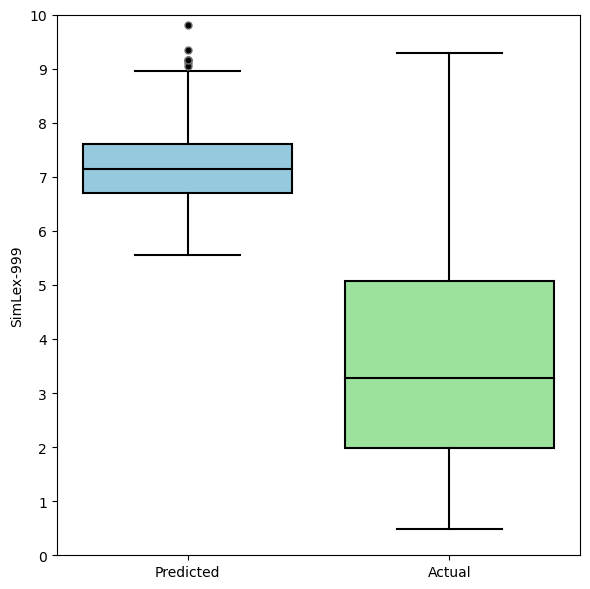

In [11]:
# Rename columns and copy
renamed_pred_sl = predicted.rename(columns={"pred_sl": "SimLex-999"}).copy()
renamed_act_sl = actual.rename(columns={"act_sl": "SimLex-999"}).copy()

# Create dummy label
renamed_pred_sl['Score'] = 'Predicted'
renamed_act_sl['Score'] = 'Actual'

# Combine DataFrames
combined_data = pd.concat([renamed_pred_sl, renamed_act_sl])

# Create boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(
    x='Score',
    y='SimLex-999',
    data=combined_data,
    palette=['skyblue', 'lightgreen'],
    boxprops={'edgecolor': 'black'},
    whiskerprops={'color': 'black'},
    flierprops={'marker': 'o', 'color': 'black', 'markerfacecolor': 'black'},
    capprops={'color': 'black'},
    medianprops={'color': 'black'}
)

# Set labels and title
plt.ylabel('SimLex-999')
# plt.title('Comparison of SimLex-999')

# Customize y-axis ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.ylim(0, 10)  # Setting y-axis limits from 0 to 10

# Remove x-axis label
plt.xlabel('')

# Adjust layout
plt.tight_layout()

# Show results
plt.show()

### **4. Distributions**

#### **4.1. SimLex-999**

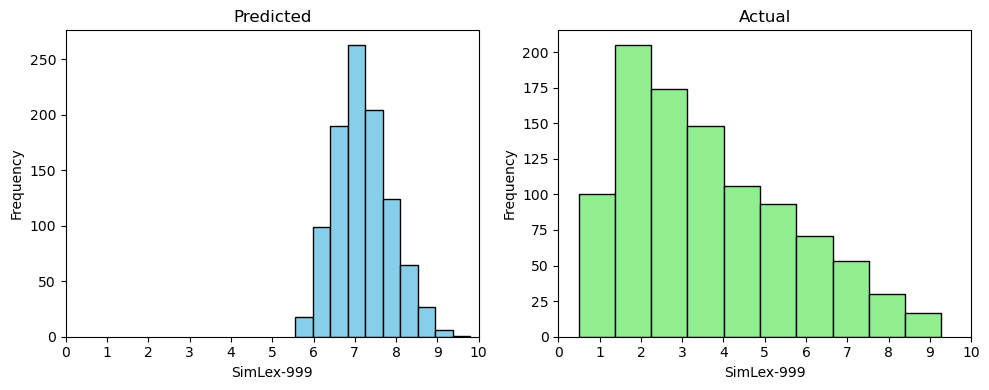

In [12]:
# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Define x-axis limits
x_min = 0
x_max = 10

# Define bins
bins = 10

# Plot predicted histogram
axes[0].hist(renamed_pred_sl['SimLex-999'], bins=bins, edgecolor='black', color='skyblue')
axes[0].set_title('Predicted')
axes[0].set_xlabel('SimLex-999')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(x_min, x_max)
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[0].grid(False) # Remove grid

# Plot actual histogram
axes[1].hist(renamed_act_sl['SimLex-999'], bins=bins, edgecolor='black', color='lightgreen')
axes[1].set_title('Actual')
axes[1].set_xlabel('SimLex-999')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(x_min, x_max)
axes[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[1].grid(False) # Remove grid

# Adjust layout
plt.tight_layout()

# Show results
plt.show()

### **5. Outliers**

#### **5.1. Predicted**

In [13]:
# Count outliers
print_outlier_counts(predicted)

Outliers in pred_sl: 7


In [14]:
# Row outliers
print_outlier_data(predicted, 'pred_sl')


Outliers in pred_sl:
            word1        word2  pred_sl
109    echtgenote   echtgenoot     9.80
125       actrice       acteur     9.10
234       bedrijf  onderneming     9.15
383   onderneming      bedrijf     9.15
569  gelukkigheid        geluk     9.35
665          buik    onderbuik     9.05
838     deelnemen      meedoen     9.15


#### **5.2. Actual**

In [15]:
# Count outliers
print_outlier_counts(actual)

No outliers found in columns: act_sl


In [16]:
# Row outliers
print_outlier_data(actual, 'act_sl')

No outliers found in act_sl


#### **5.3. Add to Summary**

In [17]:
# Calculate outliers
outliers_pred_sl = calculate_outliers(predicted, 'pred_sl')
outliers_act_sl = calculate_outliers(actual, 'act_sl')

# Count outliers
count_outliers_pred_sl = outliers_pred_sl.shape[0]
count_outliers_act_sl = outliers_act_sl.shape[0]

# Add outliers count to summary
outliers_row = pd.Series([count_outliers_pred_sl, count_outliers_act_sl], 
    index=summary_df.columns,
    name='outliers'
)
summary_df = pd.concat([summary_df, outliers_row.to_frame().T])

# Show results
summary_df

,pred_sl,act_sl
count,997.00,997.00
mean,7.19,3.64
std,0.67,1.99
min,5.55,0.49
25%,6.70,1.99
50%,7.15,3.27
75%,7.60,5.08
max,9.80,9.28
median,7.15,3.27
outliers,7.00,0.00


### **6. Evaluation Metrics**

#### **6.1. Spearmans's Rank Correlation**

##### **6.1.1. Actual SimLex-999 vs Predicted SimLex-999**

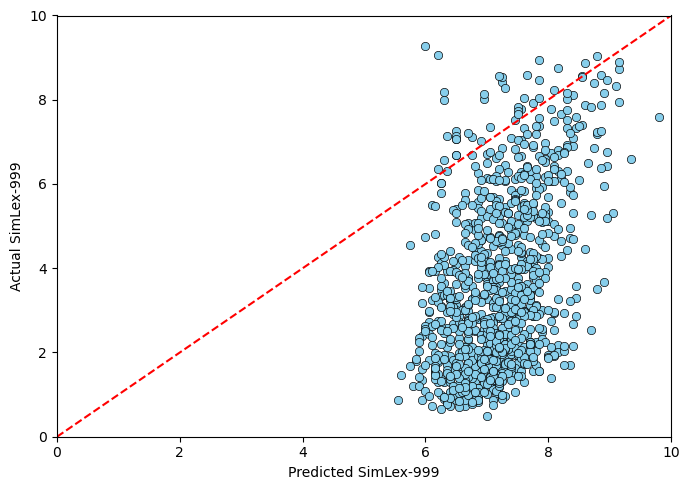

In [18]:
# Scatter plot
plot_scatter_plot(merged, 'pred_sl', 'act_sl', 'Predicted SimLex-999', 'Actual SimLex-999', 0, 10, 0, 10)

In [19]:
# Correlation and pvalue
print_correlation_and_pvalue(merged, 'pred_sl', 'act_sl')

Spearman's Rank correlation: 0.40569
P-value: 8.699665456372065e-41
The correlation is statistically significant.



#### **6.2. Mean Square Error (MSE)**

In [20]:
# Calculate Mean Squared Error
mse = mean_squared_error(merged['pred_sl'], merged['act_sl'])

# Show results
print(f"Mean Squared Error (MSE): {mse:.2f}")

Mean Squared Error (MSE): 15.79


#### **6.3. Mean Absolute Error (MAE)**

In [21]:
# Calculate Mean Absolute Error
mae = mean_absolute_error(merged['pred_sl'], merged['act_sl'])

# Show results
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 3.60


#### **6.4. Bland-Altman**

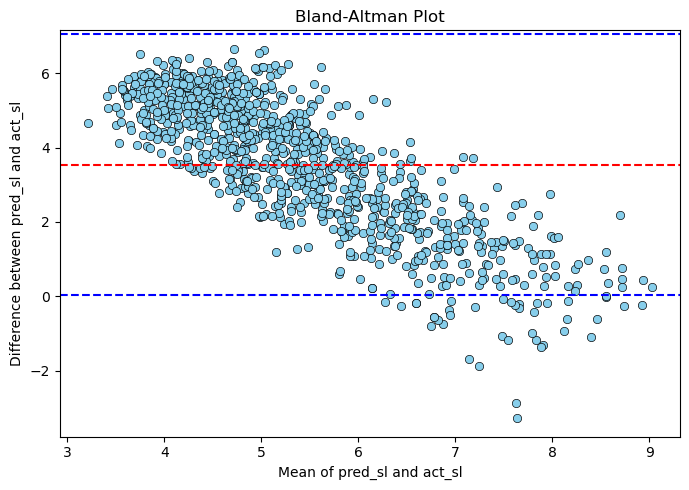

In [22]:
# SimLex-999
bland_altman_plot(data1=merged['pred_sl'], data2=merged['act_sl'])